In [13]:
# Mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [307]:
%cd /content/gdrive/My\ Drive/ParkDepot\ Test/
!ls
!python --version

/content/gdrive/My Drive/ParkDepot Test
datasets  model99,9%-0.8%.png  model99,9%.png  models  ParkDepot_technical_test
Python 3.6.9


# **ParkDepot Technical Test**

In [0]:
# Import statements
import os
import copy
import numpy as np
from matplotlib import pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import torchvision.transforms as transforms

## Restructure the data folders' architecture, to easily load data with Pytorch ImageFolder

In [0]:
import glob
import os
import unicodedata
import pathlib
paths = ['datasets/Real_Plates/', 'datasets/Synthetic_Plates/']
subpaths = ['train/', 'validation/']

def transform_filename(filename):
  filename = unicodedata.normalize('NFKD', filename).encode('ascii', 'ignore')
  label = len(filename.decode().split('_')[0])
  if label>3:
    label = 0
  # create directory in case it is not already created
  pathlib.Path(path + subpath + str(label)).mkdir(exist_ok=True) 
  return str(label) + "/" + str(filename.decode())

for path in paths:
  for subpath in subpaths:
    for filename in glob.glob(path + subpath + '*.*'):
        new_filename = transform_filename(filename.split('/')[-1]) 
        os.rename(filename, os.path.join(path + subpath, new_filename))

In [282]:
!ls -a datasets/Synthetic_Plates/train/

1  2  3


*MVF3610* and *VAM168* (in *Real_Plates/train*) have been manually changed to label 1. They were assigned to label 0 due to name inconsistency.

In [283]:
# Load datasets with ImageFolder
def create_dataset(path, verbose=False):
  compose = transforms.Compose(
        [#transforms.Resize([224, 1120]),
         transforms.Resize([40, 200]), #because some of the images have inconsistent dimensions
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
  dataset = torchvision.datasets.ImageFolder(path, transform=compose)
  if verbose:
    print(str(len(dataset)) + ' images at path '+ path)
  return dataset


def create_dataloader(dataset, batch_size):
  return torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=40, #can be increased as I only use 3.19/25.51GB max with 20 workers (on Backend Google GPU)
    shuffle=True
  )


train_dataset, validation_dataset = torch.utils.data.random_split(
    torch.utils.data.ConcatDataset(
        [create_dataset('datasets/Real_Plates/train/', True), 
        create_dataset('datasets/Synthetic_Plates/train/', True)
    ]), [7800, 1872])
test_dataset = torch.utils.data.ConcatDataset(
    [create_dataset('datasets/Real_Plates/validation/', True), 
     create_dataset('datasets/Synthetic_Plates/validation/', True)
])


create_dataset('datasets/Real_Plates/validation/', True)

dataloaders = {}

dataloaders['train'] = create_dataloader(train_dataset, 104)
dataloaders['validation'] = create_dataloader(validation_dataset, 104)
dataloaders['test'] = create_dataloader(test_dataset, 20)

for (key, dataloader) in dataloaders.items():
  print(key + ': ' + str(len(dataloader.dataset)))

700 images at path datasets/Real_Plates/train/
8972 images at path datasets/Synthetic_Plates/train/
10 images at path datasets/Real_Plates/validation/
1010 images at path datasets/Synthetic_Plates/validation/
10 images at path datasets/Real_Plates/validation/
train: 7800
validation: 1872
test: 1020


In [284]:
# Healthchecks
print(list(set(create_dataset('datasets/Real_Plates/train/').targets)))
print(list(set(create_dataset('datasets/Real_Plates/validation/').targets)))
print(list(set(create_dataset('datasets/Synthetic_Plates/validation/').targets)))
print(list(set(create_dataset('datasets/Synthetic_Plates/train/').targets)))

[0, 1, 2]
[0, 1, 2]
[0, 1, 2]
[0, 1, 2]


In [0]:
# Load smaller dataloaders to test model first
train_indices = np.random.randint(0, 100, size=40)
val_indices = np.random.randint(0, 100, size=20)

dataloaders['small_train'] = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=10, 
    sampler=torch.utils.data.RandomSampler(train_dataset, replacement=True, num_samples=40)
)
dataloaders['small_validation'] = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=18, 
    sampler=torch.utils.data.sampler.RandomSampler(validation_dataset, replacement=True, num_samples=36)
)


dataloaders['real_test'] = create_dataloader(create_dataset('datasets/Real_Plates/validation/'), 10)

Our train set has 7800 entries, our validation set 1872 and our test set 1020. *To be refined afterwards if our test set is too small*

In [286]:
# Check data
for i, (data, target) in enumerate(dataloaders['small_validation']):
  print(i, data.size(), target)

0 torch.Size([18, 3, 40, 200]) tensor([2, 1, 1, 0, 1, 2, 2, 2, 1, 1, 0, 0, 2, 1, 1, 0, 1, 1])
1 torch.Size([18, 3, 40, 200]) tensor([2, 2, 2, 0, 2, 1, 0, 1, 1, 0, 2, 2, 2, 0, 0, 1, 1, 2])


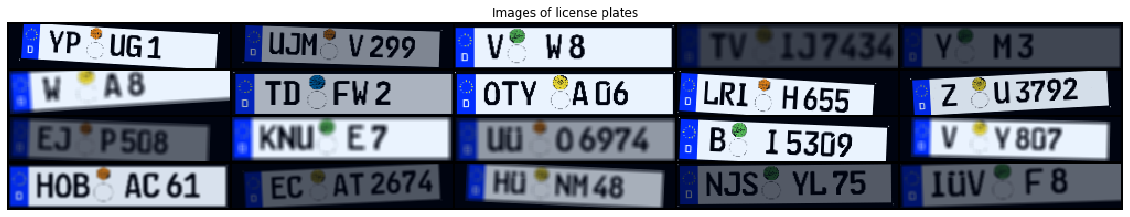

tensor([1, 2, 0, 1, 0, 0, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 1, 1, 2, 2])


In [287]:
train_batch = next(iter(dataloaders['test']))
plt.figure(figsize=(20,4))
plt.axis("off")
plt.title("Images of license plates")
data = np.transpose(vutils.make_grid(train_batch[0][:20], padding=2, normalize=True, nrow=5).cpu(),(1,2,0))
plt.imshow(data)
plt.show()
print(train_batch[1][:20])

License plates' images are of original size ***3x40x200***.

*Classes:*
- 0 = 1 letter
- 1 = 2 letters
- 2 = 3 letters

## Let's define our model

### Manual ResNet test

I use a **ResNet** model with convolutional layers following the [original paper](https://arxiv.org/abs/1512.03385) from He et al.

I manually implemented it, in case you want to assess my skills to adapt a network from a paper.

We could have taken directly *ResNet18* from Pytorch and replaced its head by a 3-classes linear layer.

`resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet18', pretrained=False, force_reload=True)` 

`resnet.fc = nn.Linear(512, 3)`




###### *Model code base*

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
      

In [0]:
class ResidualBlock(nn.Module):
    """
    The residual block used by ResNet.
    
    Args:
        in_channels: The number of channels (feature maps) of the incoming embedding
        out_channels: The number of channels after the first convolution
        stride: Stride size of the first convolution, used for downsampling
    """
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()        
        if stride > 1 or in_channels != out_channels:
            # Add strides in the skip connection and zeros for the new channels.
            self.skip = Lambda(lambda x: F.pad(x[:, :, ::stride, ::stride],
                                               (0, 0, 0, 0, 0, out_channels - in_channels),
                                               mode="constant", value=0))
        else:
            self.skip = nn.Sequential()
            
        # TODO: Initialize the required layers
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, input):
        # TODO: Execute the required layers and functions
        x1 = F.relu(self.bn1(self.conv1(input)))
        x2 = self.bn2(self.conv2(x1))
        return F.relu(x2 + self.skip(input))

In [0]:
class ResidualStack(nn.Module):
    """
    A stack of residual blocks.
    
    Args:
        in_channels: The number of channels (feature maps) of the incoming embedding
        out_channels: The number of channels after the first layer
        stride: Stride size of the first layer, used for downsampling
        num_blocks: Number of residual blocks
    """
    
    def __init__(self, in_channels, out_channels, stride, num_blocks):
        super().__init__()
        
        # TODO: Initialize the required layers (blocks)
        blocks = [ResidualBlock(in_channels, out_channels, stride=stride)]
        for _ in range(num_blocks - 1):
            blocks.append(ResidualBlock(out_channels, out_channels))
        self.blocks = nn.ModuleList(blocks)
        
    def forward(self, input):
        # TODO: Execute the layers (blocks)
        x = input
        for block in self.blocks:
            x = block(x)
        return x

##### *Our ResNet model*

In [0]:
n = 5
num_classes = 3 # 1, 2 or 3 letters

# Our manual ResNet model
resnet_manual = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    ResidualStack(16, 16, stride=1, num_blocks=n),
    ResidualStack(16, 32, stride=2, num_blocks=n),
    ResidualStack(32, 64, stride=2, num_blocks=n),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.squeeze()),
    nn.Linear(64, num_classes)
)

##### *Weight initialization*

In [0]:
def initialize_weight(module):
    if isinstance(module, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
    elif isinstance(module, nn.BatchNorm2d):
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)
        
resnet_manual.apply(initialize_weight);

##### *Helper method that does one epoch of training or evaluation*

In [0]:
def run_epoch(model, optimizer, dataloader, train, verbose=False):
    """
    Run one epoch of training or evaluation.
    
    Args:
        model: The model used for prediction
        optimizer: Optimization algorithm for the model
        dataloader: Dataloader providing the data to run our model on
        train: Whether this epoch is used for training or evaluation
        
    Returns:
        Loss and accuracy in this epoch.
    """    
    device = next(model.parameters()).device
    
    # Set model to training mode (for e.g. batch normalization, dropout)
    if train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0.0
    epoch_acc = 0.0

    # Iterate over data
    num_batches = len(dataloader)
    for n_batch, (xb, yb) in enumerate(dataloader):
        xb, yb = xb.to(device), yb.to(device)

        # zero the parameter gradients
        if train:
            optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(train):
            pred = model(xb)
            loss = F.cross_entropy(pred, yb)
            top1 = torch.argmax(pred, dim=1)
            ncorrect = torch.sum(top1 == yb)

            # backward + optimize only if in training phase
            if train:
                loss.backward()
                optimizer.step()

        # statistics
        epoch_loss += loss.item()
        epoch_acc += ncorrect.item()

        if verbose:
          print('Batch Num: [{}/{}] -- {}'.format(n_batch+1, num_batches, 'train' if train else 'eval'))
    
    epoch_loss /= len(dataloader.dataset)
    epoch_acc /= len(dataloader.dataset)

    return epoch_loss, epoch_acc

##### *A training loop [**fit** function]. I add an early stopping based on validation accuracy.*

In [0]:
def fit(model, optimizer, lr_scheduler, dataloaders, max_epochs, patience, verbose=False):
    """
    Fit the given model on the dataset.
    
    Args:
        model: The model used for prediction
        optimizer: Optimization algorithm for the model
        lr_scheduler: Learning rate scheduler that improves training
                      in late epochs with learning rate decay
        dataloaders: Dataloaders for training and validation
        max_epochs: Maximum number of epochs for training
        patience: Number of epochs to wait with early stopping the
                  training if validation loss has decreased
                  
    Returns:
        Loss and accuracy in this epoch.
        history: dictionary of loss and accuracy history
    """
    
    history = {
        'train': {'loss': [], 'accuracy': []},
        'validation': {'loss': [], 'accuracy': []}
    }
    best_acc = 0
    curr_patience = 0
    print('Start training!')
    
    for epoch in range(max_epochs):
        train_loss, train_acc = run_epoch(model, optimizer, dataloaders['train'], train=True, verbose=verbose)
        lr_scheduler.step()
        print(f"[Epoch {epoch + 1: >3}/{max_epochs}] train loss: {train_loss:.2e}, accuracy: {train_acc * 100:.2f}%")
        history['train']['loss'].append(train_loss)
        history['train']['accuracy'].append(train_acc)
        
        val_loss, val_acc = run_epoch(model, None, dataloaders['validation'], train=False, verbose=verbose)
        print(f"[Epoch {epoch + 1: >3}/{max_epochs}] val loss: {val_loss:.2e}, accuracy: {val_acc * 100:.2f}%")
        history['validation']['loss'].append(val_loss)
        history['validation']['accuracy'].append(val_acc)
        
        # TODO: Add early stopping and save the best weights (in best_model_weights)
        if val_acc >= best_acc:
            best_epoch = epoch
            best_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
                
        # Early stopping
        if epoch - best_epoch >= patience:
            break
    
    model.load_state_dict(best_model_weights)
    return history

##### *Send model to GPU*

In [295]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
resnet_manual.to(device);

cuda


##### *Healthcheck on a mini-batch*

In [301]:
_, test_acc = run_epoch(resnet_manual, None, dataloaders['test'], train=False, verbose=False)
print('Accuracy on test before training: ' + str(test_acc))

Accuracy on test before training: 0.35294117647058826


##### *Loss results printer*

In [0]:
def print_history(history):
    fig, axs = plt.subplots(2)
    fig.set_size_inches(18, 10)

    axs[0].plot(np.arange(len(history['train']['loss'])), history['train']['loss'], color='r', label='Train')
    axs[0].plot(np.arange(len(history['validation']['loss'])), history['validation']['loss'], color='g', label='Validation')
    axs[0].set_title('Loss history')
 
    axs[1].plot(np.arange(len(history['train']['accuracy'])), history['train']['accuracy'], color='r', label='Train')
    axs[1].plot(np.arange(len(history['validation']['accuracy'])), history['validation']['accuracy'], color='g', label='Validation')
    axs[1].set_title('Accuracy history')

    for i in range(2):
      axs[i].set_xlabel('Epoch')
      axs[i].legend(loc='best')
    plt.show()

##### *Model saver*

In [0]:
def save_models(model, model_name, epoch, learning_rate, weight_decay):
        out_dir = 'models/{}'.format(model_name)
        pathlib.Path('models/').mkdir(exist_ok=True) 
        pathlib.Path(out_dir).mkdir(exist_ok=True) 
        rand_num = np.random.randint(0, 100, size=1)[0]
        torch.save(model.state_dict(), '{}/epoch={}_lr={}_weightdecay={}_id={}'.format(
            out_dir, epoch, learning_rate, weight_decay, rand_num))

##### **Let's fit our model**


Start training!
[Epoch   1/30] train loss: 1.09e-02, accuracy: 44.53%
[Epoch   1/30] val loss: 1.07e-02, accuracy: 46.31%
[Epoch   2/30] train loss: 7.03e-03, accuracy: 67.85%
[Epoch   2/30] val loss: 1.09e-02, accuracy: 58.76%
[Epoch   3/30] train loss: 2.31e-03, accuracy: 91.42%
[Epoch   3/30] val loss: 2.56e-03, accuracy: 89.16%
[Epoch   4/30] train loss: 1.15e-03, accuracy: 96.19%
[Epoch   4/30] val loss: 1.36e-03, accuracy: 95.09%
[Epoch   5/30] train loss: 8.27e-04, accuracy: 97.38%
[Epoch   5/30] val loss: 6.83e-03, accuracy: 74.25%
[Epoch   6/30] train loss: 6.85e-04, accuracy: 97.69%
[Epoch   6/30] val loss: 1.72e-03, accuracy: 93.06%
[Epoch   7/30] train loss: 5.88e-04, accuracy: 98.14%
[Epoch   7/30] val loss: 8.88e-03, accuracy: 70.25%
[Epoch   8/30] train loss: 1.05e-03, accuracy: 96.54%
[Epoch   8/30] val loss: 2.26e-03, accuracy: 90.49%
[Epoch   9/30] train loss: 6.44e-04, accuracy: 97.86%
[Epoch   9/30] val loss: 4.16e-03, accuracy: 78.95%
[Epoch  10/30] train loss: 5.8

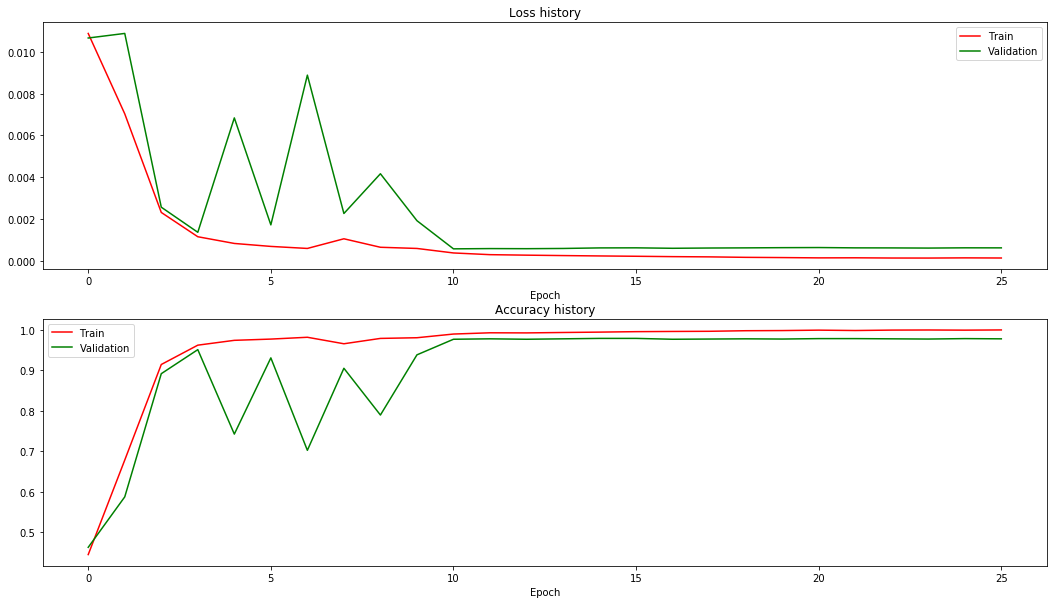

In [304]:
#optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-6, weight_decay=0e-5)
optimizer = torch.optim.SGD(resnet_manual.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-2)
#lr_scheduler to decrease learning rate over epoch
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20, 25], gamma=0.1)

# Fit model
history_manual = fit(resnet_manual, optimizer, lr_scheduler, dataloaders, max_epochs=30, patience=10)
print_history(history_manual)

##### *Accuracy on test set*

In [305]:
_, test_acc = run_epoch(resnet_manual, None, dataloaders['test'], train=False, verbose=False)
print('Accuracy on test after training: ' + str(test_acc))

Accuracy on test after training: 0.996078431372549


In [306]:
_, test_acc = run_epoch(resnet_manual, None, dataloaders['real_test'], train=False, verbose=False)
print('Accuracy on small test dataset (10 images): ' + str(test_acc))

Accuracy on small test dataset (10 images): 0.7


##### **Let's save our model**

In [0]:
save_models(resnet_manual, 'manual_resnet_tuesday_morning', 30, 8e-3, 1e-2)

## Results

I proceeded in several steps:

* **First try with the small dataset (= 10 real validation images)**

After some research over the hyperparameters, with a `SGD optimizer(lr=1e-2, weight_decay=1e-4)`, I reached a performance of 100% on both training set *(synthetic and real train images)* and validation set *(synthetic validation images)* but only **80% accuracy on test dataset** *(real validation images)*. This issue can be due to a different distribution between train and test datasets. Another issue with this split is that we validate only on real plates whereas we train on synthetic plates.

-> model saved on *models/manual_resnet_tuesday_morning/epoch=20_lr=0.01_weightdecay=0.0001_id=85*

* **Second try with a better split definition**

That's why I chose to change the a higher test dataset by adding synthetic validation images. 

- `training dataset` = 7800/9672 (~80% of train data)` images from both synthetic and real train images
- `validation dataset` = the other 1872 images (~20% of train data)
- `test dataset` = images from both synthetic and real validation images (~10% of whole data)

With a `SGD optimizer(lr=1e-2, weight_decay=1e-2)`, I reached:
- **99,9% accuracy on my test dataset**
-  **100% accuracy on the 10 real validation images**.

-> model saved on *models/manual_resnet_tuesday_morning/epoch=20_lr=0.01_weightdecay=0.01_id=92*

![History](https://drive.google.com/uc?id=1Wo_QoYIxLSY7PoZxxG580YA61YCpOm_1)





## Best model loader and test

In [0]:
def load_model(path):
  model = resnet_manual
  model.load_state_dict(torch.load(path))
  return model

In [0]:
choosen_model = load_model('models/manual_resnet_tuesday_morning/epoch=20_lr=0.01_weightdecay=0.01_id=92')

In [310]:
_, test_acc = run_epoch(choosen_model, None, dataloaders['test'], train=False, verbose=False)
print('Accuracy on test dataset: ' + str(test_acc))
_, test_acc = run_epoch(choosen_model, None, dataloaders['real_test'], train=False, verbose=False)
print('Accuracy on small test dataset (10 images): ' + str(test_acc))

Accuracy on test dataset: 0.9990196078431373
Accuracy on small test dataset (10 images): 1.0
